# Gas Dosing Demo

I created a makefile to make interacting with the Demo easier: 

Start Docker containers with the SEC Nodes running on port 10800 (gas_dosing) and 10801 (reactorcell):

 ``` make sim```

Start Containers and additionally start frappy gui:

```make frappy``` 

In [1]:
from bluesky import RunEngine
import bluesky.plan_stubs as bps
from bluesky.plan_stubs import sleep, rd
from bluesky.plans import scan, count

import databroker

from bluesky.preprocessors import run_decorator, SupplementalData
from bluesky import preprocessors as bpp
from bluesky.callbacks.best_effort import BestEffortCallback
from pprint import pprint
from secop_ophyd.SECoPDevices import SECoPNodeDevice
from bluesky.utils import ProgressBarManager

from tiled.client import from_uri


import time
from ophyd.status import Status


from bluesky.log import config_bluesky_logging

config_bluesky_logging(level='WARNING')
# Create a run engine and a temporary file backed database. Send all the documents from the RE into that database
RE = RunEngine({},call_returns_result=True)
bec = BestEffortCallback()
RE.subscribe(bec)
RE.waiting_hook = ProgressBarManager()
RE.ignore_callback_exceptions = False



#Example of adding metadata to RE environment
investigation_id = "Nexus Demonstrator"

RE.md["investigation_id"] = investigation_id


client = from_uri("http://localhost:8000",api_key="secret")

def post_document(name,doc):
    client.post_document(name, doc)
    
RE.subscribe(post_document)

# Connect to Gas Dosing SEC Node and generate ophyd device tree
gas_dosing =  SECoPNodeDevice.create('localhost','10800',RE.loop)

# Connect to Reactor Cell SEC Node and generate ophyd device tree
reactor_cell =  SECoPNodeDevice.create('localhost','10801',RE.loop)

gas_dosing.class_from_instance()
reactor_cell.class_from_instance()


from genNodeClass import *

gas_dosing:Gas_dosing = gas_dosing
reactor_cell:Reactor_cell = reactor_cell



gas_dosing ready
reactor_cell ready
no code generated yet, building from scratch


### Using the Devices
From here on out the SECoP-Ophyd devices are fully usable and behave like any other ophyd-async device. They can be incorporated into bluesky plans alongside other devices, that might have a different underlying field layer such as EPICS or TANGO.   



Transient Scan ID: 1     Time: 2024-08-20 09:12:01
Persistent Unique Scan ID: 'd0a0b3a4-aa34-4b2a-ac85-be5eadc7b7ed'
New stream: 'primary'
+-----------+------------+------------------------------------+------------------------------------+
|   seq_num |       time | reactor_cell-temperature_reg-value | reactor_cell-temperature_sam-value |
+-----------+------------+------------------------------------+------------------------------------+
|         1 | 09:12:01.7 |                            300.000 |                            294.520 |
|         2 | 09:12:02.6 |                            301.110 |                            295.838 |
|         3 | 09:12:03.6 |                            302.220 |                            297.115 |
|         4 | 09:12:04.6 |                            303.330 |                            298.358 |
|         5 | 09:12:05.6 |                            304.440 |                            299.574 |
|         6 | 09:12:06.6 |                         

RunEngineResult(run_start_uids=('d0a0b3a4-aa34-4b2a-ac85-be5eadc7b7ed',), plan_result='d0a0b3a4-aa34-4b2a-ac85-be5eadc7b7ed', exit_status='success', interrupted=False, reason='', exception=None)

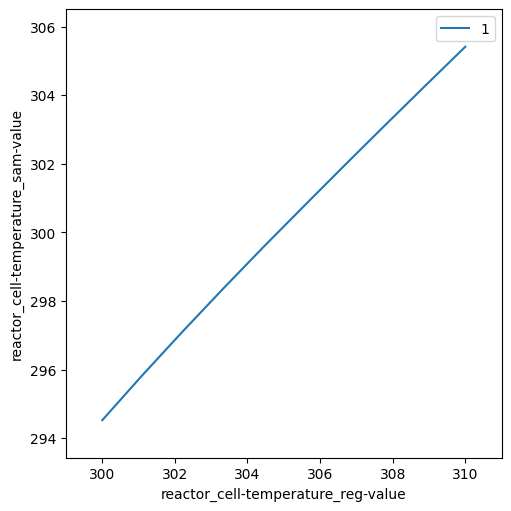

In [2]:
# Example of a scan plan:
RE(scan([reactor_cell.temperature_sam],reactor_cell.temperature_reg,300,310,10))

### SECoP Commands
One important thing about SECoP-Ophyd devices, is that they also expose SECoP Commands as bluesky plans in the form of instance methods. SECoP Commands are special operations that are implemented on the SEC node, which can be called by an ECS. They can have an argument and a return value.

In this test envirmonment the massflow controllers have such command implemented for demo purposes it is called `test_cmd` it takes in a Struct (dict) as an argument and returns a random integer. 

From the `genNodeClass.py` file the command signature can be retrieved:


``` python
    @abstractmethod 
    def test_cmd(self, arg: dict[str, Any], wait_for_idle: bool = False) -> int:
      """testing with ophyd secop integration
       argument: StructOf(name=StringType(), id=IntRange(0, 1000), sort=BoolType())
       result: IntRange()"""
```


The argument is a dict containing three entrys, a 'name' (String), an 'id' (int) and 'sort' (bool). It also sets the target, of the massflow controller to a random value, causing the device to go into a `BUSY` state. The `wait_for_idle` is option is present on every command plan and decides if plan execution should halt until the device goes back into an `IDLE` state or not. 


In [ ]:
# Call the command 

command_argument = {'name': 'test','id': 245,'sort': True}

RE(gas_dosing.massflow_contr1.test_cmd(arg=command_argument,wait_for_idle=True))



In [ ]:
# commands can also fail, for example if their arguments are invalid

command_argument = {'name': 'bad_name','id': 245,'sort': True}

RE(gas_dosing.massflow_contr1.test_cmd(arg=command_argument,wait_for_idle=True))

### A More Elaborate Example of a Simulated catalysis Experiment  

In [ ]:
"""
    assumed gas flows
    h = 12 ml/min
    hel = 10 ml /min
    c0 =3ml/min

    Assumed that mfc1 is H2, mfc2 is he, MFC3 is CO
"""

# Define the gas mix for a given gas selection in ml/min
gas_flows = {"N2":(30, 0,0),"H2":(0,15,0), "CO":(0,0,5), "Off":(0,0,0)}

def set_gas(mfc_tuple):
    
    yield from bps.mv(gas_dosing.massflow_contr1, mfc_tuple[0],gas_dosing.massflow_contr2, mfc_tuple[1],gas_dosing.massflow_contr3, mfc_tuple[2], group='mfc_setting')
    yield from bps.wait(group = 'mfc_setting', timeout= 10)
    print(f"successfully set the gas to {mfc_tuple}")

def ramp(gas_sel, temp_setpoint,temp_ramp, interval=10, md = None):

    """
    This plan will set gas mfc and temperature controllers and wait for 
    the temperature to reach a required value "temp_setpoint"

    Once the temperature has been set, it will be held for "dwell" seconds
    During this time the eiger will be triggered as before 
    
    Parameters
    ------------
    gas_sel: string
        The gas to be selected ('N2', 'H2', 'CO')
    temp_setpoint : float
        temperature to be reached. Until this temperature is reached, stay in this loop
    temp_ramp : float 
        degrees/ min to ramp at. Can be positive or negative. If negative there is just no heat
    interval : int
        seconds between triggers after an acquisition has finished
    md : dict
        A dictionary of additional metadata


    """

    # Set the temperature ramp rate
    yield from bps.abs_set(reactor_cell.temperature_reg.ramp, float(temp_ramp), wait=True)    

    # Set the Gas
    print(f"Setting the gas to {gas_sel} -> {gas_flows[gas_sel]}")
    yield from set_gas(gas_flows[str(gas_sel)])

    # yield from set_abs(reactor_c.temperature_reg, temp_setpoint)
    print(f"Starting to change the temperature to {temp_setpoint}")
    complete_status = yield Msg('set', reactor_cell.temperature_reg, temp_setpoint)

    # Since we have no readback from gas analysis on actual gas env, 
    # the only thing we can do is wait for a known time
    print(f"Starting the acquire loop while temperature is changing")
    while not complete_status.done:
        
        yield from bps.one_shot([reactor_cell.temperature_reg,reactor_cell.temperature_sam]) 

        yield from bps.checkpoint()
        yield from sleep(interval)
    
    # We are actually never waiting on the gas to get anywhere
    #gas_status = Status(timeout= min_gas_time)

    # Read but don't save the temperature value
    val = yield from rd(reactor_cell.temperature_reg.value)
    print(f"Temperature Achieved: {val}C" )


def dwell(gas_sel,dwell, interval=10, md = None):

    """
    This plan will set gas mfc and wait there for a given amount of time

    During this period the eiger will be triggered 
    A delay of "interval" can be set between triggers
    
    Parameters
    ------------
    gas_sel: string
        The gas to be selected ('he', 'H2', 'CO')
    dwell : int 
        seconds to dwell at this state for
    interval : int
        seconds between triggers after an acquisition has finished
    md : dict
        A dictionary of additional metadata

    -------

    """

    # Set the Gas
    print(f"Setting the gas to {gas_sel} -> {gas_flows[gas_sel]}")
    yield from set_gas(gas_flows[str(gas_sel)])

    # Now stay here for a given amount of time
    dwell_status = Status(timeout=dwell)
    while not dwell_status.done:
        yield from bps.one_shot([reactor_cell.temperature_reg,reactor_cell.temperature_sam]) #triggers and reads everything in the detectors list
        yield from bps.checkpoint()
        yield from sleep(interval)
                

import numpy as np


def cat1():

    md = {'sample':'sample 5' , 'operator': 'HZB'}

    @bpp.run_decorator(md = md)
    def inner_plan():
        #Times all ramps by 10 and dwell divided by 60
        yield from ramp(gas_sel='N2', temp_setpoint=35 + 273.15, temp_ramp=20)
        yield from dwell(gas_sel='N2',dwell=1*60)

        yield from ramp(gas_sel='H2', temp_setpoint=125 + 273.15, temp_ramp=20)
        yield from dwell(gas_sel='H2',dwell=1*60)

        yield from ramp(gas_sel='CO', temp_setpoint=35 + 273.15, temp_ramp=20)
        yield from dwell(gas_sel='Off',dwell=1*60)
        

    return (yield from inner_plan())

RE(cat1())